In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q pyspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00


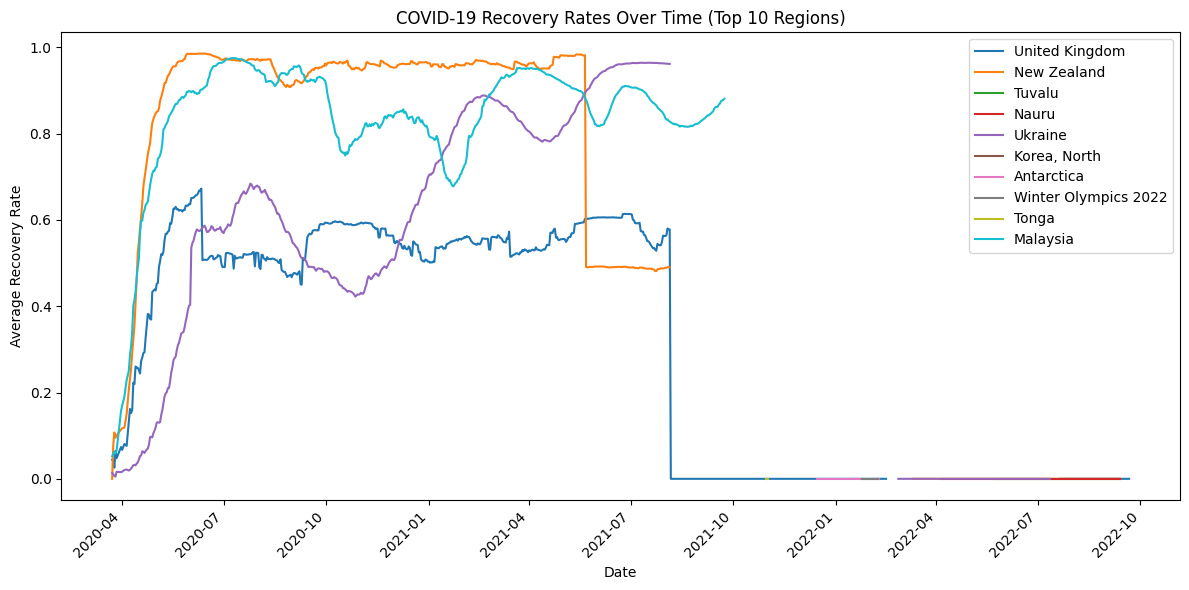

In [ ]:


# Step 2: Import necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg
import matplotlib.pyplot as plt

# Step 3: Initialize a SparkSession
spark = SparkSession.builder \
    .appName("COVID Recovery Rate Analysis") \
    .getOrCreate()

# Step 4: Load the dataset into a Spark DataFrame
df = spark.read.csv('/content/drive/MyDrive/cleaned_dataset.csv', header=True, inferSchema=True)

# Step 5: Clean the data - Remove rows with null or invalid values
df_clean = df.filter(
    (col('Confirmed').isNotNull()) &
    (col('Recovered').isNotNull()) &
    (col('Last_Update').isNotNull())
)

# Step 6: Calculate Recovery Rate (Recovered / Confirmed) and filter out cases where the recovery rate is NaN
df_clean = df_clean.withColumn('recovery_rate', col('Recovered') / col('Confirmed'))

# Step 7: Register the DataFrame as a temporary SQL table to use SQL queries
df_clean.createOrReplaceTempView('covid_data')

# Step 8: Use Spark SQL to aggregate by region and date, and calculate average recovery rates
recovery_rate_sql = """
SELECT
    Country_Region,
    DATE(Last_Update) AS date,
    AVG(recovery_rate) AS avg_recovery_rate
FROM
    covid_data
GROUP BY
    Country_Region, date
ORDER BY
    date, avg_recovery_rate DESC
"""
result_df = spark.sql(recovery_rate_sql)

# Step 9: Collect results to a Pandas DataFrame (for plotting)
result_pandas_df = result_df.toPandas()

# Step 10: Plotting (matplotlib) the recovery rate for top regions
top_regions = result_pandas_df['Country_Region'].value_counts().head(10).index  # Get top 10 regions by count

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the recovery rate for each region
for region in top_regions:
    region_data = result_pandas_df[result_pandas_df['Country_Region'] == region]
    ax.plot(region_data['date'], region_data['avg_recovery_rate'], label=region)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Average Recovery Rate")
ax.set_title("COVID-19 Recovery Rates Over Time (Top 10 Regions)")

# Improve the x-axis labels
plt.xticks(rotation=45, ha='right')

# Add a legend
ax.legend()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



**Time-Based Trends**

In [ ]:
from pyspark.sql import functions as F

# Convert 'Last_Update' column to a timestamp if it's not already
df_clean = df_clean.withColumn("Last_Update", F.to_timestamp("Last_Update"))

# Add 'week_of_year' and 'month' columns
df_clean = df_clean.withColumn('week_of_year', F.weekofyear('Last_Update'))
df_clean = df_clean.withColumn('month', F.month('Last_Update'))


In [ ]:
# Register the DataFrame as a temporary SQL table
df_clean.createOrReplaceTempView("covid_data")


<ipython-input-24-5604a680b27b>:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


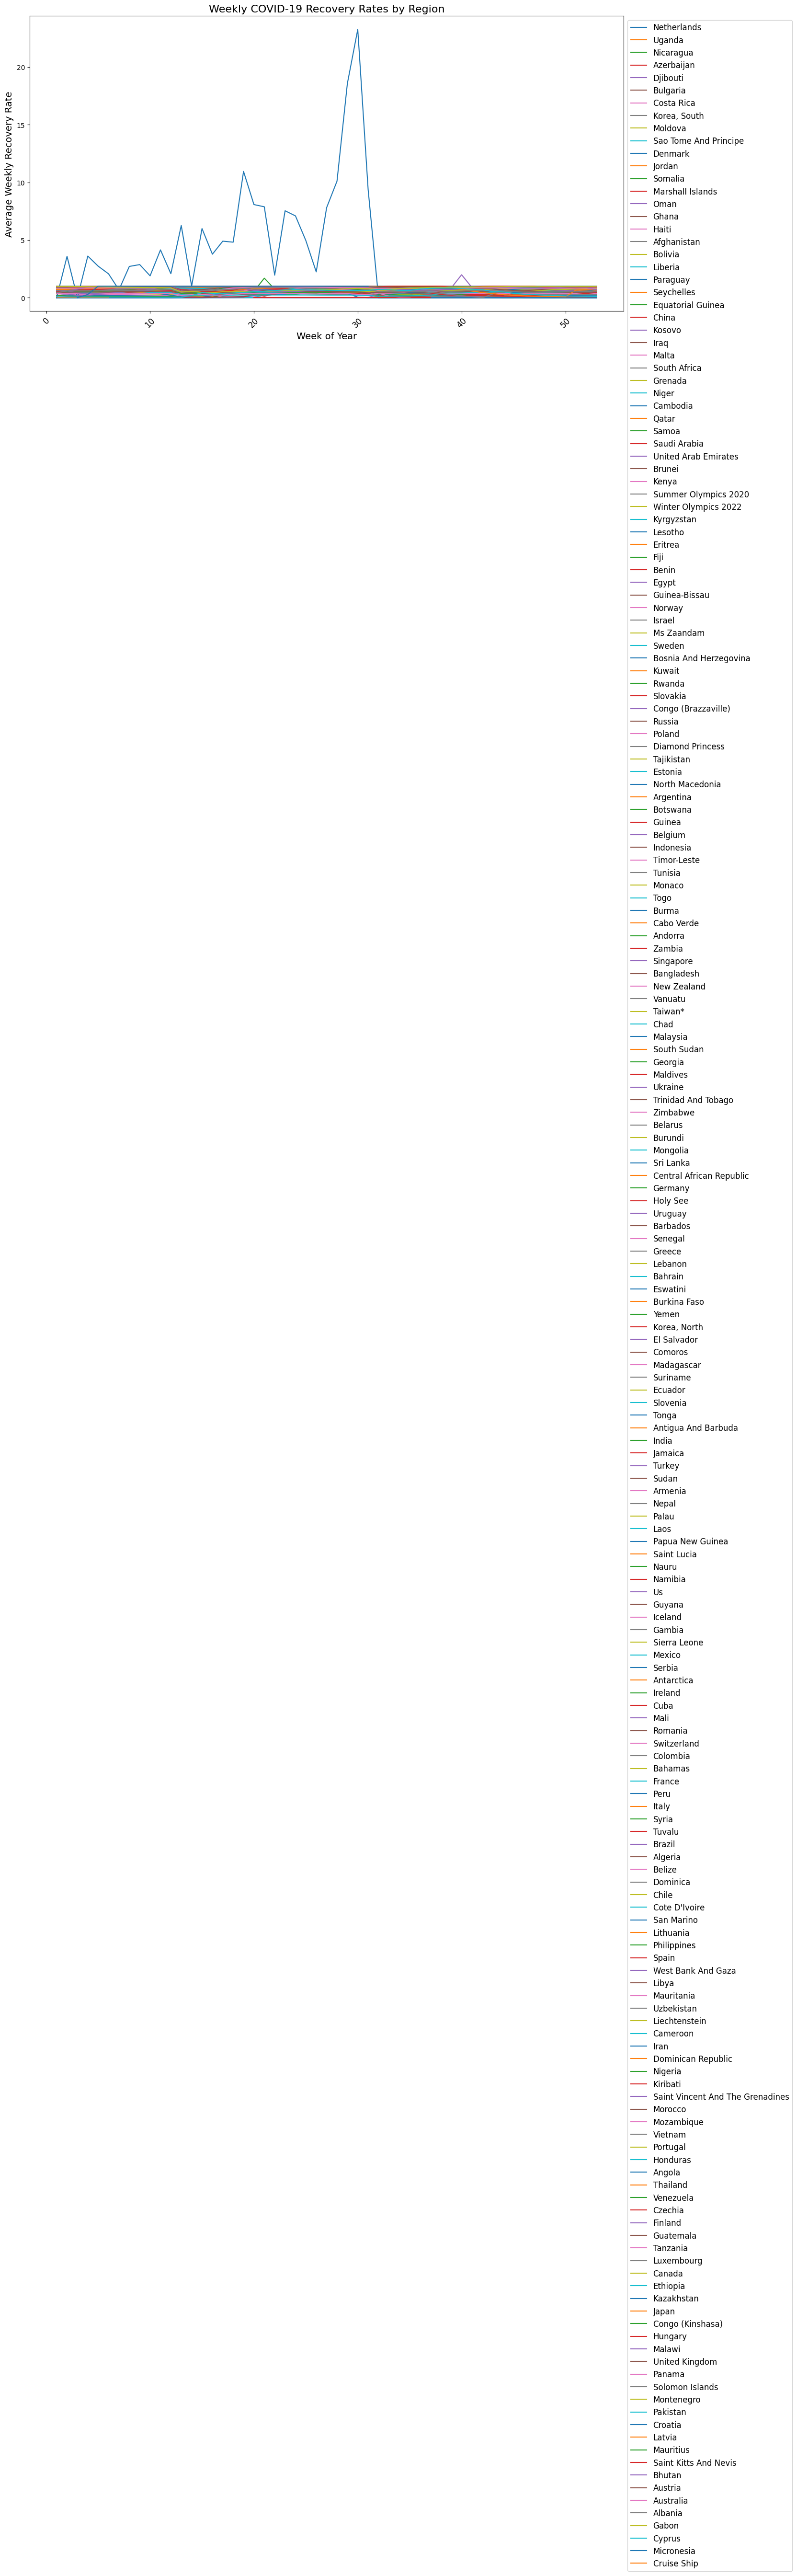

In [ ]:
# SQL query to calculate weekly recovery rate
weekly_recovery_rate_sql = """
SELECT
    Country_Region,
    week_of_year,
    AVG(recovery_rate) AS avg_weekly_recovery_rate
FROM
    covid_data
GROUP BY
    Country_Region, week_of_year
ORDER BY
    week_of_year
"""

# Execute the query
weekly_recovery_rate_df = spark.sql(weekly_recovery_rate_sql)

# Convert the result to Pandas for visualization
weekly_recovery_rate_pandas = weekly_recovery_rate_df.toPandas()

import matplotlib.pyplot as plt

# Ensure the figure is large enough for clarity
plt.figure(figsize=(16, 8))

# Iterate over unique regions and plot each region's data
for region in weekly_recovery_rate_pandas['Country_Region'].unique():
    region_data = weekly_recovery_rate_pandas[weekly_recovery_rate_pandas['Country_Region'] == region]

    # Plot each region's weekly recovery rate trend
    plt.plot(region_data['week_of_year'], region_data['avg_weekly_recovery_rate'], label=region)

# Add plot title and labels
plt.title("Weekly COVID-19 Recovery Rates by Region", fontsize=16)
plt.xlabel("Week of Year", fontsize=14)
plt.ylabel("Average Weekly Recovery Rate", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Display the legend outside the plot to avoid clutter
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Use tight_layout to ensure everything fits within the figure
plt.tight_layout()

# Show the plot
plt.show()



**Regional Variations**

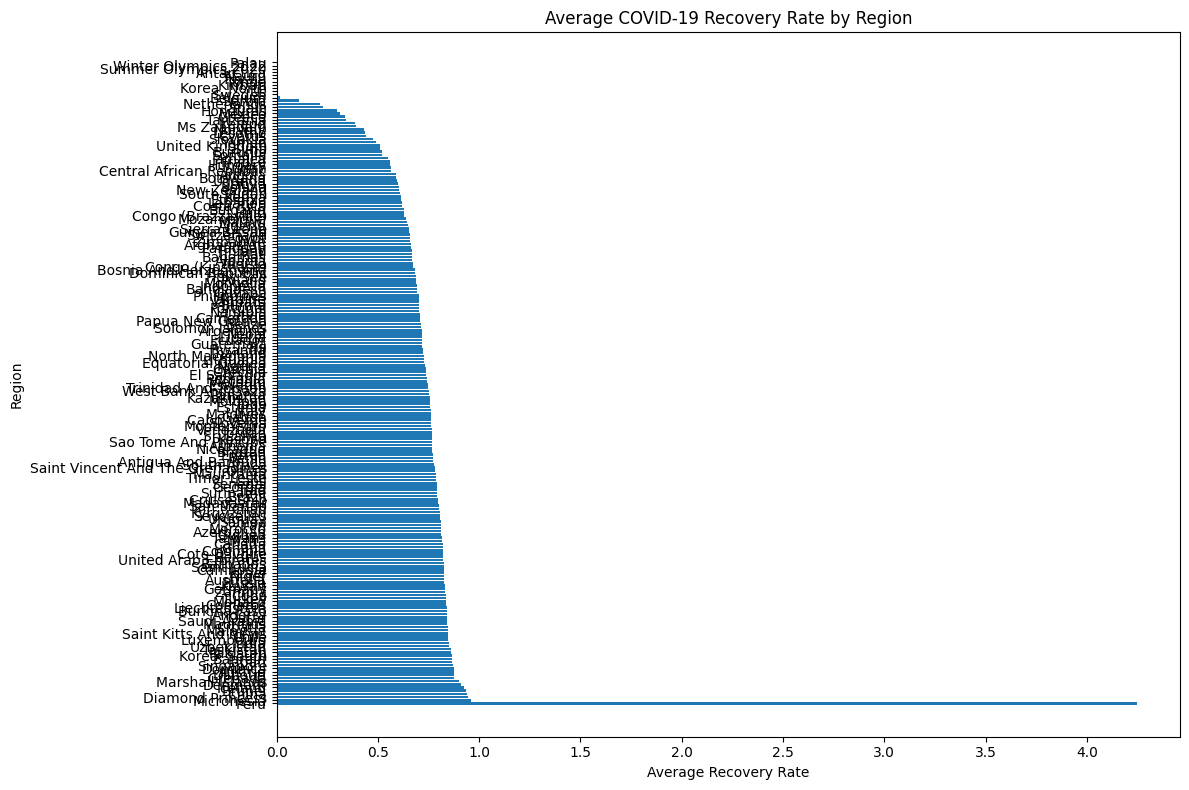

In [ ]:
# Step 1: Calculate average recovery rate by region
regional_recovery_rate_sql = """
SELECT
    Country_Region,
    AVG(recovery_rate) AS avg_recovery_rate
FROM
    covid_data
GROUP BY
    Country_Region
ORDER BY
    avg_recovery_rate DESC
"""
regional_recovery_rate_df = spark.sql(regional_recovery_rate_sql)

# Step 2: Convert to Pandas for plotting
regional_recovery_rate_pandas = regional_recovery_rate_df.toPandas()

# Step 3: Plot the recovery rates by region
plt.figure(figsize=(12, 8))
plt.barh(regional_recovery_rate_pandas['Country_Region'], regional_recovery_rate_pandas['avg_recovery_rate'])
plt.title("Average COVID-19 Recovery Rate by Region")
plt.xlabel("Average Recovery Rate")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


**Recovery Rate Comparison by Continent/Group**

In [ ]:
country_recovery_rate_sql = """
    SELECT Country_Region, AVG(recovery_rate) AS avg_recovery_rate
    FROM covid_data
    GROUP BY Country_Region
    ORDER BY avg_recovery_rate DESC
"""

country_recovery_rate_df = spark.sql(country_recovery_rate_sql)
country_recovery_rate_df.show()


+----------------+------------------+
|  Country_Region| avg_recovery_rate|
+----------------+------------------+
|            Peru| 4.247317878834124|
|      Micronesia|0.9591836734693877|
|Diamond Princess|0.9470431396729699|
|           China|0.9374020558722401|
|          Brunei|0.9340450492101813|
|         Iceland|0.9233086570157497|
|         Denmark|0.9113280758219473|
|Marshall Islands| 0.900355871886121|
|         Grenada|0.8765695468090319|
|        Djibouti|0.8747320084983008|
|         Austria|0.8746509520617873|
|        Dominica|0.8745899707130252|
|       Singapore|0.8717985667644372|
|           Japan|0.8674518885192143|
|         Bahrain|0.8663536983171825|
|    Korea, South|0.8662369541548218|
|        Pakistan|0.8630287913128175|
|      Tajikistan|0.8608819470582982|
|      Uzbekistan|0.8515170813491127|
|           India|0.8497967536275859|
+----------------+------------------+
only showing top 20 rows

